In [58]:
import os
import shutil
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import yaml
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import datasets, models, transforms
from torchvision.utils import save_image
from torch.utils.data import random_split
from torch.utils.data.dataloader import DataLoader
from torchvision.utils import make_grid
import sys
sys.path.append('..')
from template import utils

In [73]:
utils.set_random_seeds()

In [3]:
from torch.utils.tensorboard import SummaryWriter

2024-01-12 13:29:17.882081: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-12 13:29:17.882103: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-01-12 13:29:17.883043: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-01-12 13:29:17.888118: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-01-12 13:29:18.593379: W tensorflow/compiler/tf2

In [44]:
import wandb
wandb.login()

wandb: Currently logged in as: freddie7 (luke_team). Use `wandb login --relogin` to force relogin


True

In [4]:
# GAN_LOGS = os.path.join(os.getcwd(), "tboard_logs", "gan")
# if not os.path.exists(GAN_LOGS):
#     os.makedirs(GAN_LOGS)

In [5]:
# # shutil.rmtree(GAN_LOGS)
# writer = SummaryWriter(GAN_LOGS)

In [6]:
# if not os.path.exists("imgs"):
#     os.makedirs("imgs")
# #shutil.rmtree("imgs/training")
# if not os.path.exists("imgs/training"):
#     os.makedirs("imgs/training")

In [74]:
# Downloading and Loading Dataset
svhn_tf = transforms.Compose([
        transforms.ToTensor(),
        # transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        # transforms.Pad(2),
      #  transforms.Normalize(mean=(0.5, ), std=(0.5, ))
    ])

In [75]:
dataset = datasets.SVHN(root='./data', transform=svhn_tf, download=True)
#test_dataset = datasets.SVHN(root='./data', train=False, transform=svhn_tf, download=True)

Using downloaded and verified file: ./data/train_32x32.mat


In [76]:
val_size = 6000
train_size = len(dataset) - val_size

train_ds, val_ds = random_split(dataset, [train_size, val_size])
len(train_ds), len(val_ds)

(67257, 6000)

In [77]:
config = yaml.safe_load(open("config.yaml"))
batch_size = int(config["BATCH_SIZE"])

print(f"Our config: {config}")

Our config: {'BATCH_SIZE': 64, 'NUM_EPOCHS': 10, 'LR': '3e-4'}


In [78]:
train_loader = DataLoader(train_ds, batch_size, shuffle=True, num_workers=4)
val_loader = DataLoader(val_ds, batch_size*2, num_workers=4)

images.shape: torch.Size([64, 3, 32, 32])


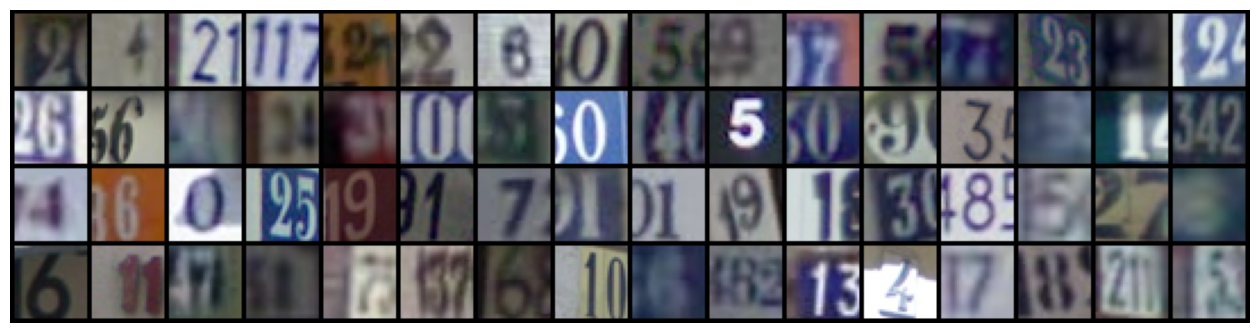

In [79]:
for images, _ in train_loader:
    print('images.shape:', images.shape)
    plt.figure(figsize=(16,8))
    #plt.set_title(f"Img #{n}  Label: {train_dataset[n][1]}")
    plt.axis('off')
    plt.imshow(make_grid(images, nrow=16).permute((1, 2, 0)))
    break

In [80]:
class ConvBlock(nn.Module):
    """
    Simple convolutional block: Conv + Norm + Act + Dropout
    """
    
    def __init__(self, in_channels, out_channels, kernel_size=3, stride=1, add_norm=True, activation="ReLU", dropout=None):
        """ Module Initializer """
        super().__init__()
        assert activation in ["ReLU", "LeakyReLU", "Sigmoid", "Tanh", None]
        padding = kernel_size // 2
        
        block = []
        block.append(nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, padding=padding, stride=stride))
        if add_norm:
            block.append(nn.BatchNorm2d(out_channels))
        if activation is not None:
            nonlinearity = getattr(nn, activation, nn.ReLU)()
            if isinstance(nonlinearity, nn.LeakyReLU):
                nonlinearity.negative_slope = 0.2
            block.append(nonlinearity)
            
        if dropout is not None:
            block.append(nn.Dropout(dropout))
            
        self.block =  nn.Sequential(*block)

    def forward(self, x):
        """ Forward pass """
        y = self.block(x)
        return y


class ConvTransposeBlock(nn.Module):
    """
    Simple convolutional block: ConvTranspose + Norm + Act + Dropout
    """
    
    def __init__(self, in_channels, out_channels, kernel_size=3, stride=1, add_norm=True, activation="ReLU", dropout=None):
        """ Module Initializer """
        super().__init__()
        assert activation in ["ReLU", "LeakyReLU", "Tanh", None]
        padding = kernel_size // 2
        
        block = []
        block.append(nn.ConvTranspose2d(in_channels, out_channels, kernel_size=kernel_size, padding=1, stride=stride))
        if add_norm:
            block.append(nn.BatchNorm2d(out_channels))
        if activation is not None:
            nonlinearity = getattr(nn, activation, nn.ReLU)()
            if isinstance(nonlinearity, nn.LeakyReLU):
                nonlinearity.negative_slope = 0.2
            block.append(nonlinearity)
        if dropout is not None:
            block.append(nn.Dropout(dropout))
            
        self.block =  nn.Sequential(*block)

    def forward(self, x):
        """ Forward pass """
        y = self.block(x)
        return y

In [81]:
class Reshape(nn.Module):
    """ Reshaping a vector in a given shape """
    
    def __init__(self, shape):
        """ """
        super().__init__()
        self.shape = shape
        
    def forward(self, x):
        """ """
        B, N = x.shape
        x = x.view(B, N, 1, 1)
        y = x.repeat(1, 1, *self.shape)
        return y

In [104]:
class Generator(nn.Module):
    """
    A fully convolutional generator using ReLU activations. 
    Takes as input a latent vector and outputs a fake sample.
       (B, latent_dim, 1, 1)  --> (B, num_channels, 32, 32)
    """
    def __init__(self, latent_dim=128, num_channels=3, base_channels=32):
        """ Model initializer """
        super().__init__()
        self.num_classes = num_classes
        layers = []
        for i in range(4):
            layers.append(
                ConvTransposeBlock(
                        in_channels=latent_dim if i == 0 else base_channels * 2 ** (3-i+1),
                        out_channels=base_channels * 2 ** (3-i),
                        kernel_size=4,
                        stride=1 if i == 0 else 2,
                        add_norm=True,
                        activation="ReLU"
                    )
                )
        layers.append(
            ConvTransposeBlock(
                    in_channels=base_channels,
                    out_channels=num_channels,
                    kernel_size=4,
                    stride=2,
                    add_norm=False,
                    activation="Tanh"
                )
            )
        
        self.model = nn.Sequential(*layers)
        return
    
    def forward(self, z, labels):
        labels = labels.view(labels.shape[0], self.num_classes, 1, 1)
        z = torch.cat([z, labels], dim=1)
        """ Forward pass through generator """
        y = self.model(x)
        return y

In [105]:
class Discriminator(nn.Module):
    """ A fully convolutional discriminator using LeakyReLU activations. 
    Takes as input either a real or fake sample and predicts its autenticity.
       (B, num_channels, 32, 32)  -->  (B, 1, 1, 1)
    """
    def __init__(self, in_channels=1, out_dim=1, base_channels=32, dropout=0.3, num_classes=10):
        """ Module initializer """
        super().__init__()  
        self.num_classes = num_classes
        layers = []
        for i in range(4):
            layers.append(
                ConvBlock(
                        in_channels=in_channels if i == 0 else base_channels * 2 ** i,
                        out_channels=base_channels * 2 ** (i + 1),
                        kernel_size=4,
                        add_norm=True,
                        activation="LeakyReLU",
                        dropout=dropout,
                        stride=2
                    )
                )
        layers.append(
                ConvBlock(
                        in_channels=base_channels * 16,
                        out_channels=out_dim,
                        kernel_size=4,
                        stride=4,
                        add_norm=False,
                        activation="Sigmoid"
                    )
                )
        
        self.model = nn.Sequential(*layers)
        return
      
    def forward(self, x, labels):
        """ Forward pass """
        labels = labels.view(labels.shape[0], 1, 1, 1).repeat(1, self.num_classes, x.shape[2], x.shape[3])
        x = torch.cat([x, labels], dim=1)
        y = self.model(x)
        return y

In [84]:
discriminator = Discriminator(in_channels=3, out_dim=1, base_channels=32)
generator = Generator(latent_dim=128, num_channels=3, base_channels=32)

In [85]:
latent = torch.randn(16, 128, 1, 1)
fake_img = generator(latent)
score = discriminator(fake_img)
print(f"{fake_img.shape = }")
print(f"{score.shape = }")

fake_img.shape = torch.Size([16, 3, 32, 32])
score.shape = torch.Size([16, 1, 1, 1])


In [86]:
# utils
def smooth(f, K=5):
    """ Smoothing a function using a low-pass filter (mean) of size K """
    kernel = np.ones(K) / K
    f = np.concatenate([f[:int(K//2)], f, f[int(-K//2):]])  # to account for boundaries
    smooth_f = np.convolve(f, kernel, mode="same")
    smooth_f = smooth_f[K//2: -K//2]  # removing boundary-fixes
    return smooth_f


def count_model_params(model):
    """ Counting the number of learnable parameters in a nn.Module """
    num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    return num_params

def visualize_progress(loss_iters, train_loss, val_loss):
    """ Visualizing loss and accuracy """
    fig, ax = plt.subplots(1,3)
    fig.set_size_inches(24,5)

    smooth_loss = smooth(loss_iters, 31)
    ax[0].plot(loss_iters, c="blue", label="Loss", linewidth=3, alpha=0.5)
    ax[0].plot(smooth_loss, c="red", label="Smoothed Loss", linewidth=3, alpha=1)
    ax[0].legend(loc="best")
    ax[0].set_xlabel("Iteration")
    ax[0].set_ylabel("CE Loss")
    ax[0].set_yscale("log")
    ax[0].set_title("Training Progress")

    smooth_loss = smooth(loss_iters, 31)
    START = 500
    N_ITERS = len(loss_iters)
    ax[1].plot(np.arange(START, N_ITERS), loss_iters[START:], c="blue", label="Loss", linewidth=3, alpha=0.5)
    ax[1].plot(np.arange(START, N_ITERS), smooth_loss[START:], c="red", label="Smoothed Loss", linewidth=3, alpha=1)
    ax[1].legend(loc="best")
    ax[1].set_xlabel("Iteration")
    ax[1].set_ylabel("CE Loss")
    ax[1].set_yscale("log")
    ax[1].set_title(f"Training Progress from Iter {START}")

    epochs = np.arange(len(train_loss)) + 1
    ax[2].plot(epochs[1:], train_loss[1:], c="red", label="Train Loss", linewidth=3)
    ax[2].plot(epochs[1:], val_loss[1:], c="blue", label="Valid Loss", linewidth=3)
    ax[2].legend(loc="best")
    ax[2].set_xlabel("Epochs")
    ax[2].set_ylabel("CE Loss")
    ax[2].set_title("Loss Curves")

In [97]:
class Trainer:
    """
    Class for initializing GAN and training it
    """
    def __init__(self, generator, discriminator, latent_dim=128):
        """ Initialzer """
        self.latent_dim = latent_dim
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.generator = generator.to(self.device)
        self.discriminator = discriminator.to(self.device)
        
        self.optim_discriminator = torch.optim.Adam(self.discriminator.parameters(), lr=3e-4, betas=(0.5, 0.9))
        self.optim_generator = torch.optim.Adam(self.generator.parameters(), lr=3e-4, betas=(0.5, 0.9))
        
        # REAL LABEL = 1
        # FAKE LABEL = 0
        # eps = 1e-10
        # self.criterion_d_real = lambda pred: torch.clip(-torch.log(1 - pred + eps), min=-10).mean()
        # self.criterion_d_fake = lambda pred: torch.clip(-torch.log(pred + eps), min=-10).mean()
        # self.criterion_g = lambda pred: torch.clip(-torch.log(1 - pred + eps), min=-10).mean()
        
        self.criterion_d_real = lambda pred: F.binary_cross_entropy(pred, torch.ones(pred.shape[0], device=pred.device))
        self.criterion_d_fake = lambda pred: F.binary_cross_entropy(pred, torch.zeros(pred.shape[0], device=pred.device))
        self.criterion_g = lambda pred: F.binary_cross_entropy(pred, torch.ones(pred.shape[0], device=pred.device))
        
        self.hist = {
            "d_real": [],
            "d_fake": [],
            "g": []
        }
        return
        
    def train_one_step(self, imgs, labels):
        """ 
        raining both models for one optimization step
        """
        self.generator.train()
        self.discriminator.train()
        
        # Sample from the latent distribution
        B = imgs.shape[0]
        latent = torch.randn(B, self.latent_dim, 1, 1).to(self.device)
        
        real_labels = torch.ones(batch_size, 1, device=device)
        fake_labels = torch.zeros(batch_size, 1, device=device)
        # ==== Training Discriminator ====
        self.optim_discriminator.zero_grad()
        # Get discriminator outputs for the real samples
        prediction_real = self.discriminator(imgs, labels)
        # Compute the loss function
        d_loss_real = self.criterion_d_real(prediction_real.view(B), real_labels)

        # Generating fake samples with the generator
        fake_samples = self.generator(latent, labels)
        # Get discriminator outputs for the fake samples
        prediction_fake_d = self.discriminator(fake_samples.detach(), labels)  # why detach?
        # Compute the loss function
        d_loss_fake = self.criterion_d_fake(prediction_fake_d.view(B), fake_labels)
        (d_loss_real + d_loss_fake).backward()
        assert fake_samples.shape == imgs.shape
        
        # optimization step
        torch.nn.utils.clip_grad_norm_(self.discriminator.parameters(), 3.0)
        self.optim_discriminator.step()
        
        # === Train the generator ===
        self.optim_generator.zero_grad()
        # Get discriminator outputs for the fake samples
        prediction_fake_g = self.discriminator(fake_samples, labels)
        # Compute the loss function
        g_loss = self.criterion_g(prediction_fake_g.view(B), real_labels)
        g_loss.backward()
        # optimization step
        self.optim_generator.step()
        
        return d_loss_real, d_loss_fake, g_loss
    
    @torch.no_grad()
    def generate(self, N=64):
        """ Generating a bunch of images using current state of generator """
        self.generator.eval()
        latent = torch.randn(N, self.latent_dim, 1, 1).to(self.device)
        imgs = self.generator(latent)
        imgs = imgs * 0.5 + 0.5
        return imgs
        
    def train(self, data_loader, N_iters=10000, init_step=0):
        """ Training the models for several iterations """
        
        progress_bar = tqdm(range(init_step, N_iters))
        running_d_loss = 0
        running_g_loss = 0
        
        iter_ = 0
        for i in progress_bar:
            for real_batch, labels in data_loader:           
                real_batch = real_batch.to(self.device)
                labels = labels.to(device)
                d_loss_real, d_loss_fake, g_loss = self.train_one_step(imgs=real_batch, labels=labels)
                d_loss = d_loss_real + d_loss_fake
            
                # updating progress bar
                progress_bar.set_description(f"Ep {i+1} Iter {iter_}: D_Loss={round(d_loss.item(),5)}, G_Loss={round(g_loss.item(),5)})")
                
                # adding stuff to tensorboard
                # Log metrics to wandb
                wandb.log({"Loss/Generator Loss": g_loss.item(), "global_step": iter_, "epoch": i+1})
                wandb.log({"Loss/Discriminator Loss": d_loss.item(), "global_step": iter_, "epoch": i+1})
                wandb.log({"Loss/Discriminator Losses/Real Images Loss": d_loss_real.item(), "global_step": iter_, "epoch": i+1})
                wandb.log({"Loss/Discriminator Losses/Fake Images Loss": d_loss_fake.item(), "global_step": iter_, "epoch": i+1})
                wandb.log({"Comb_Loss/Losses/Discriminator": d_loss.item(), "global_step": iter_, "epoch": i+1})
                wandb.log({"Comb_Loss/Losses/Generator": g_loss.item(), "global_step": iter_, "epoch": i+1})
                
                if(iter_ % 200 == 0):
                    imgs = self.generate()
                    grid = torchvision.utils.make_grid(imgs, nrow=8)
                    images = wandb.Image(grid, caption="Top: Output, Bottom: Input")
                    wandb.log({"generated_images": images})
                    torchvision.utils.save_image(grid, os.path.join(os.getcwd(), "imgs", "training", f"imgs_{iter_}.png"))

                iter_ = iter_ + 1 
                
        return

In [94]:
# shutil.rmtree(GAN_LOGS)
# writer = SummaryWriter(GAN_LOGS)

In [101]:
generator = Generator(latent_dim=256, num_channels=3, base_channels=32)
discriminator = Discriminator(in_channels=3, out_dim=1, base_channels=32)

trainer = Trainer(generator=generator, discriminator=discriminator, latent_dim=256)

In [103]:
with wandb.init(project="DCGAN6a"):
    trainer.train(data_loader=train_loader, N_iters = 10000)
wandb.finish()

Ep 40 Iter 41491: D_Loss=0.00032, G_Loss=19.88729):   0%|                         | 39/10000 [09:26<40:11:52, 14.53s/it]
Traceback (most recent call last):
  File "/tmp/ipykernel_3071893/1373371478.py", line 2, in <module>
    trainer.train(data_loader=train_loader, N_iters = 10000)
  File "/tmp/ipykernel_3071893/1446250035.py", line 96, in train
    d_loss_real, d_loss_fake, g_loss = self.train_one_step(imgs=real_batch)
  File "/tmp/ipykernel_3071893/1446250035.py", line 62, in train_one_step
    self.optim_discriminator.step()
  File "/home/user/rogf1/miniconda3/envs/lab2/lib/python3.10/site-packages/torch/optim/optimizer.py", line 373, in wrapper
    out = func(*args, **kwargs)
  File "/home/user/rogf1/miniconda3/envs/lab2/lib/python3.10/site-packages/torch/optim/optimizer.py", line 76, in _use_grad
    ret = func(self, *args, **kwargs)
  File "/home/user/rogf1/miniconda3/envs/lab2/lib/python3.10/site-packages/torch/optim/adam.py", line 163, in step
    adam(
  File "/home/user/rogf

wandb: ERROR Control-C detected -- Run data was not synced


KeyboardInterrupt: 

In [25]:
import imageio

images = []
img_path = os.path.join(os.getcwd(), "imgs", "training")

# making list with images and orting by iteration
img_list = [img for img in os.listdir(img_path) if "imgs_" in img]
sorted_imgs = sorted(img_list, key=lambda x: int(x.split("_")[1].split(".")[0]))
for img in sorted_imgs:
    images.append(imageio.imread(os.path.join(img_path, img)))
imageio.mimsave(os.path.join(img_path, "progress.gif"), images)

/tmp/ipykernel_3071893/3686072989.py:10: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  images.append(imageio.imread(os.path.join(img_path, img)))


In [26]:
imgs = trainer.generate()
grid = torchvision.utils.make_grid(imgs, nrow=8)

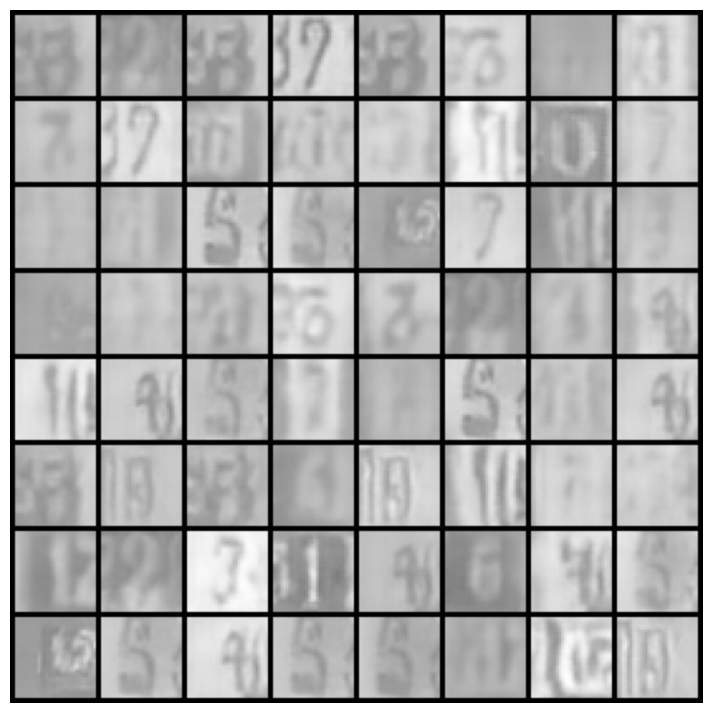

In [29]:
plt.figure(figsize=(9,9))
plt.imshow(grid[0].cpu(), cmap="gray")
plt.axis("off")
plt.show()